In [1]:
# Loading required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import xlrd
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OneHotEncoder

In [2]:
#Reading the data files
CustomerData = pd.read_csv("QVI_purchase_behaviour.csv")
TransactionData = pd.read_excel("QVI_transaction_data.xlsx")

## Exploratory Data Analysis

Examining the Data and making sure it is in a usable format.

In [3]:
# Creating a copy of the transaction dataset for quick reset or safety.
trans_df = TransactionData.copy()
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


From the above data we can see that DATE column is in integer format which needs to be in datetime format.

In [4]:
# Change date from xls integer dates to date format in customer data
trans_df['DATE'] = pd.to_datetime(trans_df['DATE'], unit='D', origin='1899-12-30')
print(trans_df['DATE'].dtype) # check format of replacement date column 

datetime64[ns]


We need to make sure that only Chips purchase data is being examined.

In [5]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


In [6]:
#Viewing all unique entries in the PROD_NAME column
trans_df['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

While it looks like we have chips, we want to check that the products are only chips by counting the word frequencies in the product names. To make this process clearer, we can remove the digits and symbols from the names.

In [7]:
# Remove digits from the product names
prod_name = trans_df['PROD_NAME'].str.replace(r'[0-9]+[gG]','');

# Remove & characters from the product names and replace with a space to separate flavours
prod_name = prod_name.str.replace(r'&',' ');

C:\Users\admin\AppData\Local\Temp/ipykernel_2680/545723120.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  prod_name = trans_df['PROD_NAME'].str.replace(r'[0-9]+[gG]','');


In [8]:
# Count the frequencies of words in product names and display counts in descending order
word_counts = pd.Series(' '.join(prod_name).split()).value_counts()

with pd.option_context('display.max_rows', None): # show all rows
  display(word_counts)

Chips              49770
Kettle             41288
Smiths             28860
Salt               27976
Cheese             27890
Pringles           25102
Doritos            24962
Crinkle            23960
Corn               22063
Original           21560
Cut                20754
Chip               18645
Chicken            18577
Salsa              18094
Chilli             15390
Sea                14145
Thins              14075
Sour               13882
Crisps             12607
Vinegar            12402
RRD                11894
Sweet              11060
Infuzions          11057
Supreme            10963
Chives             10951
Cream              10723
WW                 10320
Popd                9693
Cobs                9693
Tortilla            9580
Tostitos            9471
Twisties            9454
BBQ                 9434
Sensations          9429
Lime                9347
Paso                9324
Dip                 9324
Old                 9324
El                  9324
Tomato              7669


Some entries in our data are salsas; we want to remove these.

In [9]:
# Remove salsas from the dataset
trans_df = trans_df[trans_df['PROD_NAME'].str.contains(r"[Ss]alsa") == False]
trans_df.shape # check for a reduction in no of rows 

(246742, 8)

Now we can create summaries of the data (eg min, max, mean) to see if there are any obvious outliers in the data and if there are any nulls in any of the columns.

In [10]:
#Create summaries of the transactions data
trans_df.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [11]:
#checking for any null values
trans_df.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

From the summary, there is at least one transaction with 200 packets. Let's investigate this purchase further.

In [12]:
#Filtering the entries that have 200 packets
trans_df.loc[trans_df['PROD_QTY']==200.0]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


The same customer has made these transactions. They could have been for commercial purposes so we can check to see if they made any other purchases.

In [13]:
# Filter the entires by the customer
trans_df.loc[trans_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It looks like this is the only purchase they have made so we will remove these transactions from the dataset.

In [14]:
# Remove the transactions
trans_df = trans_df[trans_df['LYLTY_CARD_NBR'] != 226000]
trans_df.shape # check for a reduction of 2 rows (i.e. 246740 rows)

(246740, 8)

In [15]:
#Rechecking the data summary
trans_df.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


The summaries now look reasonable. Now look at the number of transaction lines over time to see if there are any obvious data issues such as missing data from particular days.

In [16]:
# Count transactions by date to see if there are any missing days 
count = trans_df.groupby(trans_df['DATE'].dt.date).size().reset_index(name = 'COUNT')
count.shape

(364, 2)

In [17]:
# There is one day of data missing. First check the range of dates by sorting in time order. 
trans_df.sort_values(by='DATE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
9161,2018-07-01,88,88140,86914,25,Pringles SourCream Onion 134g,2,7.4
155442,2018-07-01,60,60276,57330,3,Kettle Sensations Camembert & Fig 150g,2,9.2
181349,2018-07-01,199,199014,197623,104,Infuzions Thai SweetChili PotatoMix 110g,2,7.6
229948,2018-07-01,35,35052,31630,11,RRD Pc Sea Salt 165g,1,3.0
104647,2018-07-01,72,72104,71038,20,Doritos Cheese Supreme 330g,2,11.4
...,...,...,...,...,...,...,...,...
10254,2019-06-30,112,112141,114611,98,NCC Sour Cream & Garden Chives 175g,2,6.0
113220,2019-06-30,207,207155,205513,99,Pringles Sthrn FriedChicken 134g,2,7.4
229182,2019-06-30,10,10140,9882,12,Natural Chip Co Tmato Hrb&Spce 175g,2,6.0
229015,2019-06-30,6,6258,6047,29,French Fries Potato Chips 175g,1,3.0


We can see that the dates range from 1 Jul 2018 to 30 Jun 2019. Now we want to check through the year of dates to see which day the data is missing.

In [18]:
# Generating a list of dates with transactions in ascending order
date_counts = trans_df.groupby('DATE').size()

# Comparing to a full list of dates within the same range ro find differences between them
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

The missing date is Christmas Day, a public holiday, so it is expected that there are no sales on this day. 
Now we will move on to creating other features such as the pack siz and chekcing this for any outliers.

In [19]:
# Add a new column to data with packet sizes and extract sizes from product name column
trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)

# Sort by packet sizes to check for outliers 
trans_df.sort_values(by='PACK_SIZE')

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\admin\AppData\Local\Temp/ipykernel_2680/1567714024.py:2: DeprecationWarning: invalid escape sequence \d
  trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
40783,2018-09-25,97,97067,96696,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42461,2019-05-05,110,110030,111890,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
176183,2018-12-30,82,82183,81660,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
227309,2018-12-03,236,236091,239098,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42418,2018-11-05,109,109217,111470,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
...,...,...,...,...,...,...,...,...,...
192034,2019-03-12,100,100121,99145,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
255797,2019-01-19,235,235098,238018,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
233814,2019-01-24,151,151102,149810,4,Dorito Corn Chp Supreme 380g,1,6.5,380.0
131573,2018-07-09,213,213087,212416,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0


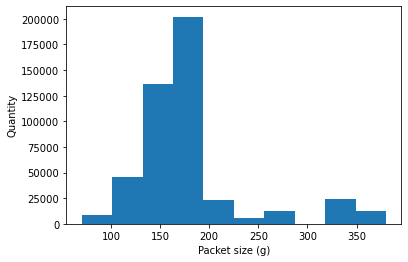

In [20]:
# Minimum packet size is 70g while max is 380g.
# Plotting a histogram to visualize distribution of pack sizes.
plt.hist(trans_df['PACK_SIZE'], weights=trans_df['PROD_QTY'])
plt.xlabel('Packet size (g)')
plt.ylabel('Quantity')
plt.show()

Packet size looks reasonable. Now we can create the brand names using the first word of each product.

In [21]:
# Adding a column to extract the first word of each product name 
trans_df.insert(9, "BRAND_NAME", trans_df["PROD_NAME"].str.split().str.get(0), True)
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos


In [22]:
# Printing all unique entries to check the brand name created
trans_df["BRAND_NAME"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

Some brand names have been doubled up. Replacing all contractions and double ups with their full name.

In [23]:
# Create a function to identify the string replacements needed.
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 
    
# Applying the function to clean the brand name
trans_df["BRAND_NAME"] = trans_df.apply(lambda line: replace_brandname(line), axis = 1)

# Checking for any duplicates.
trans_df["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

The brand names seem reasonable, without any duplicates.
Now we will examine the customer data. We can generate summaries and check the categories in this dataset.